# MLP Hyperparameter Tuning and Training 

In [0]:
# import libraries
from pyspark.sql import SparkSession, functions as F
from pyspark.sql import Window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, NumericType, DateType, DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.sql.functions import col, count, mean, stddev, min, max, when, isnan, countDistinct, lit, to_timestamp, to_date, hour, avg, sum, date_sub, current_date, datediff, floor, row_number, date_format, weekofyear, year, round, substring, concat, regexp_replace, lag, last, rank, unix_timestamp, expr, ntile, rand, monotonically_increasing_id
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import optuna
import gc
from functools import partial

In [0]:
app_name = "basic-training"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

## Load data

In [0]:
train_data = spark.read.parquet("dbfs:/FileStore/tables/train_data3.parquet")
test_data = spark.read.parquet("dbfs:/FileStore/tables/test_data3.parquet")


# switch is_accident to label
train_data = train_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")
test_data = test_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")


In [0]:
# drop labelm id columns , and EDA feature 
drop_columns = ['zipcode',"trip_date",  'vehicle_id_encoded', 'driver_id_encoded']

# drop 
drop_columns.extend(["year", "month"])

train_data = train_data.drop(*drop_columns)
test_data = test_data.drop(*drop_columns)

schema = train_data.schema

## Set up pipeline

In [0]:
# find non-numerical columns
numerical_cols = [field.name for field in schema if isinstance(field.dataType, NumericType) and field.name != "label"]
non_numerical_cols = [field.name for field in schema if not isinstance(field.dataType, NumericType)]

# Show results
print("Non-numerical columns:", non_numerical_cols)

Non-numerical columns: []


In [0]:
label_counts=train_data.groupBy('label').count()
counts = {row["label"]: row["count"] for row in label_counts.collect()}

# Assign positive and negative counts
num_positive = counts.get(1, 0)
num_negative = counts.get(0, 0)

print(f"Positive (label=1): {num_positive}")
print(f"Negative (label=0): {num_negative}")

# create POS weight
scale_pos_weight = num_negative / num_positive
print(f"Scale positive weight: {scale_pos_weight}")

train_data = train_data.withColumn(
    "class_weight",
    when(col("label") == 1, scale_pos_weight).otherwise(1.0)
)

Positive (label=1): 260
Negative (label=0): 166819
Scale positive weight: 641.6115384615384


#### Assemble Features 

In [0]:
# Drop zero importance feature columns from GBTClassifier (and all group columns)
zero_importance_features = ['last_has_issues',
 'vehicle_rolling_15trip_num_issues',
 'vehicle_rolling_15trip_issues_distance',
 'vehicle_rolling_15trip_issues_minutes',
 'vehicle_rolling_15trip_issues_events',
 'vehicle_rolling_15trip_issues_given_date',
 'prev_sum_travel_distance',
 'prev_sum_minutes_driving',
 'years_since_min_trip_date',
 'driver_sum_travel_distance_roll15d',
 'driver_sum_minutes_driving_roll15d',
 'crash_roll15d',
 'driver_facing_cam_obstruction_roll15d',
 'drowsiness_roll15d',
 'forward_collision_warning_roll15d',
 'manual_event_roll15d',
 'near_miss_roll15d',
 'ran_a_red_light_roll15d',
 'road_facing_cam_obstruction_roll15d',
 'stop_sign_violation_roll15d',
 'unsafe_lane_change_roll15d',
 'total_events_per_trip_roll15d',
 'high_roll15d',
 'ratio_camera_obstruction_roll15d_per_year',
 'ratio_crash_roll15d_per_year',
 'ratio_driver_facing_cam_obstruction_roll15d_per_year',
 'ratio_drowsiness_roll15d_per_year',
 'ratio_forward_collision_warning_roll15d_per_year',
 'ratio_manual_event_roll15d_per_year',
 'ratio_ran_a_red_light_roll15d_per_year',
 'ratio_road_facing_cam_obstruction_roll15d_per_year',
 'ratio_seat_belt_violation_roll15d_per_year',
 'ratio_tailgating_roll15d_per_year',
 'ratio_unsafe_lane_change_roll15d_per_year',
 'ratio_total_events_per_trip_roll15d_per_year',
 'ratio_trip_ts_roll15d_per_year',
 'ratio_low_roll15d_per_year',
 'ratio_high_roll15d_per_year',
 'prev_review_rate_per_km',
 'prev_review_rate_per_min',
 'prev_review_rate_per_event',
 'group_wi__buckys',
 'group_ga_psi_augusta',
 'group_nc__denver',
 'group_tn__memphis__safety_quip',
 'group_fl__freedom',
 'group_fl__jw_craft',
 'group_ms__american_johnny',
 'group_fl__gainsville_porta_serve',
 'group_pa__port_a_bowl',
 'group_ia__cedar_rapids',
 'group_ga__gci',
 'group_ms__gotta_go',
 'group_pa__malvern',
 'group_tx__forza',
 'group_tn__fusionsite_(clark)',
 'group_san_angelo_tops_septic',
 'group_wi__stranders',
 'group_az__stamback_admin',
 'group_oh__rent__a__john',
 'group_az__stamback_rolloffs_',
 'group_nc__griffin_hook_trucks',
 'group_tn__maxwell_septic',
 'group_ky__lex',
 'group_nc__asc',
 'group_tn__chattanooga_bolles',
 'group_tn__etp_',
 'group_sc__littlejohn',
 'group_tx__acp',
 'group_va__r_r',
 'group_sc__psi_columbia',
 'group_ky__bullitt_sep_service',
 'group_ky__moon_minis',
 'group_ky__moon_leasing',
 'group_nc__greensboro',
 'group_tn__fusionsite_(woodycrest)',
 'group_ky__moon_portables',
 'group_tx__j_bar',
 'group_ar__fay',
 'group_lubbock_hd_',
 'group_az__stamback_septic',
 'group_kermit',
 'group_lubbock',
 'group_wi__cesspool',
 'group_tn__fusionsite_(nashville)',
 'group_tn__mc_septic',
 'group_ny__a__john',
 'group_nc__griffin_waste_pump_trucks',
 'group_oh__c_l_and_safeway',
 'group_ar__little_rock'
 'total_fatalities_prev_3m_avg',
 'total_vehicles_prev_3m_avg']

In [0]:
# Drop zero_importance_features from train_df and test_df
train_data = train_data.drop(*zero_importance_features)
test_data = test_data.drop(*zero_importance_features)

In [0]:
# Function to make sure train/val split is stratified 
def stratified_split(df, label_col="label", train_frac=0.8, seed=42):
    fractions = df.select(label_col).distinct().withColumn(
        "fraction", F.lit(train_frac)
    ).rdd.collectAsMap()
    
    # Sample by class
    train_subset = df.stat.sampleBy(label_col, fractions, seed)
    
    # Get the validation set as the remaining data
    # Using a left anti join to get rows in df that aren't in train_subset
    validation_subset = df.join(
        train_subset, 
        on=df.columns, 
        how="left_anti"
    )
    return train_subset, validation_subset

## Cross-Validation

In [0]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.sql import functions as F
import numpy as np
import time

In [0]:
train_subset, validation_subset = stratified_split(train_data)

In [0]:
# Combine the train and validation subsets with a column indicating which is which
from pyspark.sql.functions import lit

# Add a column to indicate training vs validation data
train_with_indicator = train_subset.withColumn("train_val_indicator", lit(0))  # 0 for training
val_with_indicator = validation_subset.withColumn("train_val_indicator", lit(1))  # 1 for validation

# Union the datasets
combined_data = train_with_indicator.union(val_with_indicator)

In [0]:
train_with_indicator = train_subset.withColumn("train_val_indicator", lit(0))  # 0 for training
val_with_indicator = validation_subset.withColumn("train_val_indicator", lit(1))  # 1 for validation

# Union the datasets
combined_data = train_with_indicator.union(val_with_indicator)

feature_cols = [col for col in train_data.columns if col not in ['label', 'class_weight', 'train_val_indicator']]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")

# Add StandardScaler to normalize the features
scaler = StandardScaler(
    inputCol="assembled_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Get the number of features and classes
num_features = len(feature_cols)
num_classes = train_data.select("label").distinct().count()

# Define the MLP stage without the weightCol parameter if it's causing issues
mlp_no_early_stopping = MultilayerPerceptronClassifier(
    labelCol="label", 
    featuresCol="features",
    predictionCol="prediction",
    layers=[num_features, 10, int(num_classes)],  # Initial value
    maxIter=100,
    seed=42
)

# Create a pipeline with all stages
pipeline_no_early_stopping = Pipeline(stages=[assembler, scaler, mlp_no_early_stopping])

# Create a focused parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(mlp_no_early_stopping.layers, [
        [num_features, 10, int(num_classes)], 
        [num_features, 16, 8, int(num_classes)]
    ]) \
    .addGrid(mlp_no_early_stopping.stepSize, [0.001, 0.01, 0.1]) \
    .build()

# Create the evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Create the CrossValidator with the train_val_indicator column
custom_validator = CrossValidator(
    estimator=pipeline_no_early_stopping,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=2,
    foldCol="train_val_indicator",
    seed=42
)

In [0]:
## V2

train_with_indicator = train_subset.withColumn("train_val_indicator", lit(0))  # 0 for training
val_with_indicator = validation_subset.withColumn("train_val_indicator", lit(1))  # 1 for validation

# Union the datasets
combined_data = train_with_indicator.union(val_with_indicator)

feature_cols = [col for col in train_data.columns if col not in ['label', 'class_weight', 'train_val_indicator']]

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")

# Add StandardScaler to normalize the features
scaler = StandardScaler(
    inputCol="assembled_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# Get the number of features and classes
num_features = len(feature_cols)
num_classes = train_data.select("label").distinct().count()

# Define the MLP stage without the weightCol parameter if it's causing issues
mlp_no_early_stopping = MultilayerPerceptronClassifier(
    labelCol="label", 
    featuresCol="features",
    predictionCol="prediction",
    layers=[num_features, 10, int(num_classes)],  # Initial value
    maxIter=100,
    seed=42
)

# Create a pipeline with all stages
pipeline_no_early_stopping = Pipeline(stages=[assembler, scaler, mlp_no_early_stopping])

# Create a focused parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(mlp_no_early_stopping.layers, [
        [num_features, 10, int(num_classes)], 
        [num_features, 16, 8, int(num_classes)]
    ]) \
    .addGrid(mlp_no_early_stopping.stepSize, [0.001, 0.01, 0.1]) \
    .build()

# Create the evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Create the CrossValidator with the train_val_indicator column
custom_validator = CrossValidator(
    estimator=pipeline_no_early_stopping,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=2,
    foldCol="train_val_indicator",
    seed=42
)

In [0]:
# Making sure dimensions make sense before running full scale tuning 
test_pipeline = Pipeline(stages=[assembler, scaler])
transformed_data = test_pipeline.fit(combined_data).transform(combined_data)
actual_feature_size = len(transformed_data.select("features").first()[0])
print(f"Actual feature size: {actual_feature_size}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Actual feature size: 52


In [0]:
# Making sure dimensions make sense before running full scale tuning 
test_pipeline = Pipeline(stages=[assembler, scaler])
transformed_data = test_pipeline.fit(combined_data).transform(combined_data)
actual_feature_size = len(transformed_data.select("features").first()[0])
print(f"Actual feature size: {actual_feature_size}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Actual feature size: 48


In [0]:
print(f"Actual feature size: {actual_feature_size}")

Actual feature size: 52


In [0]:
# Fit the model
custom_model = custom_validator.fit(combined_data)

In [0]:
# Get the best model
best_pipeline_model = custom_model.bestModel
best_mlp_model = best_pipeline_model.stages[-1]

In [0]:
custom_model.avgMetrics

[0.5031010844704371,
 0.5031010844704371,
 0.5031010844704371,
 0.5065232321126227,
 0.5065232321126227,
 0.5065232321126227]

In [0]:
# Create the evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

In [0]:
# Print best model parameters
print("Best model parameters:")
print(f"Layers: {best_mlp_model.getLayers()}")
print(f"Step Size: {best_mlp_model.getStepSize()}")

# Make predictions on test data
predictions = best_pipeline_model.transform(test_data)

# Evaluate the model
auroc = evaluator.evaluate(predictions)
print(f"Test AUROC: {auroc}")

Best model parameters:
Layers: [52, 16, 8, 2]
Step Size: 0.001
Test AUROC: 0.49972322476363396


In [0]:
best_model = custom_model.bestModel

# Now train the final model on all data
# First, combine all your data without the train/val split
final_data = train_data  

In [0]:
# Create the final pipeline with the same components as before
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
final_scaler = StandardScaler(
    inputCol="assembled_features",
    outputCol="features",
    withStd=True,
    withMean=True
)

# # Extract the best parameters from the CV model
# best_layers = best_model.stages[-1].getLayers()  # Extract best layer configuration
# best_step_size = best_model.stages[-1].getStepSize()  # Extract best step size

best_layers =[num_features, 16, 8, 2]
best_step_size = 0.001

# Define the final MLP model with the best parameters
final_mlp = MultilayerPerceptronClassifier(
    labelCol="label",
    featuresCol="features",
    predictionCol="prediction",
    layers=best_layers,
    stepSize=best_step_size,
    maxIter=100,  
    seed=42
)

# Create the final pipeline
final_pipeline = Pipeline(stages=[final_assembler, final_scaler, final_mlp])

# Train the final model on all data
final_model = final_pipeline.fit(final_data)

In [0]:
# Make predictions on test data
final_train_predictions = final_model.transform(train_data)

# Evaluate the model
auroc = evaluator.evaluate(final_train_predictions)
print(f"Test AUROC: {auroc}")

Test AUROC: 0.9097222830640519


In [0]:
auprc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedPrecision"
)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedRecall"
)
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="f1"
)

In [0]:
auprc = auprc_evaluator.evaluate(final_train_predictions)
precision = precision_evaluator.evaluate(final_train_predictions)
recall = recall_evaluator.evaluate(final_train_predictions)
f1 = f1_evaluator.evaluate(final_train_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auroc}")
print(f"AUPRC: {auprc}")

Precision: 0.9988103657921114
Recall: 0.9988089466659484
F1 Score: 0.9984401122298834
AUC: 0.9097222830640519
AUPRC: 0.19190631000335617


In [0]:
# Calculate metrics using PySpark DataFrame operations
from pyspark.sql.functions import sum, when, col

# Calculate TP, FP, TN, FN using DataFrame operations
metrics = final_train_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = final_train_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

In [0]:
print(f"TPR (True Positive Rate): {tpr:.4f}")
print(f"FPR (False Positive Rate): {fpr:.4f}")
print(f"PPV (Positive Predictive Value): {ppv:.4f}")

TPR (True Positive Rate): 0.2346
FPR (False Positive Rate): 0.0000
PPV (Positive Predictive Value): 1.0000


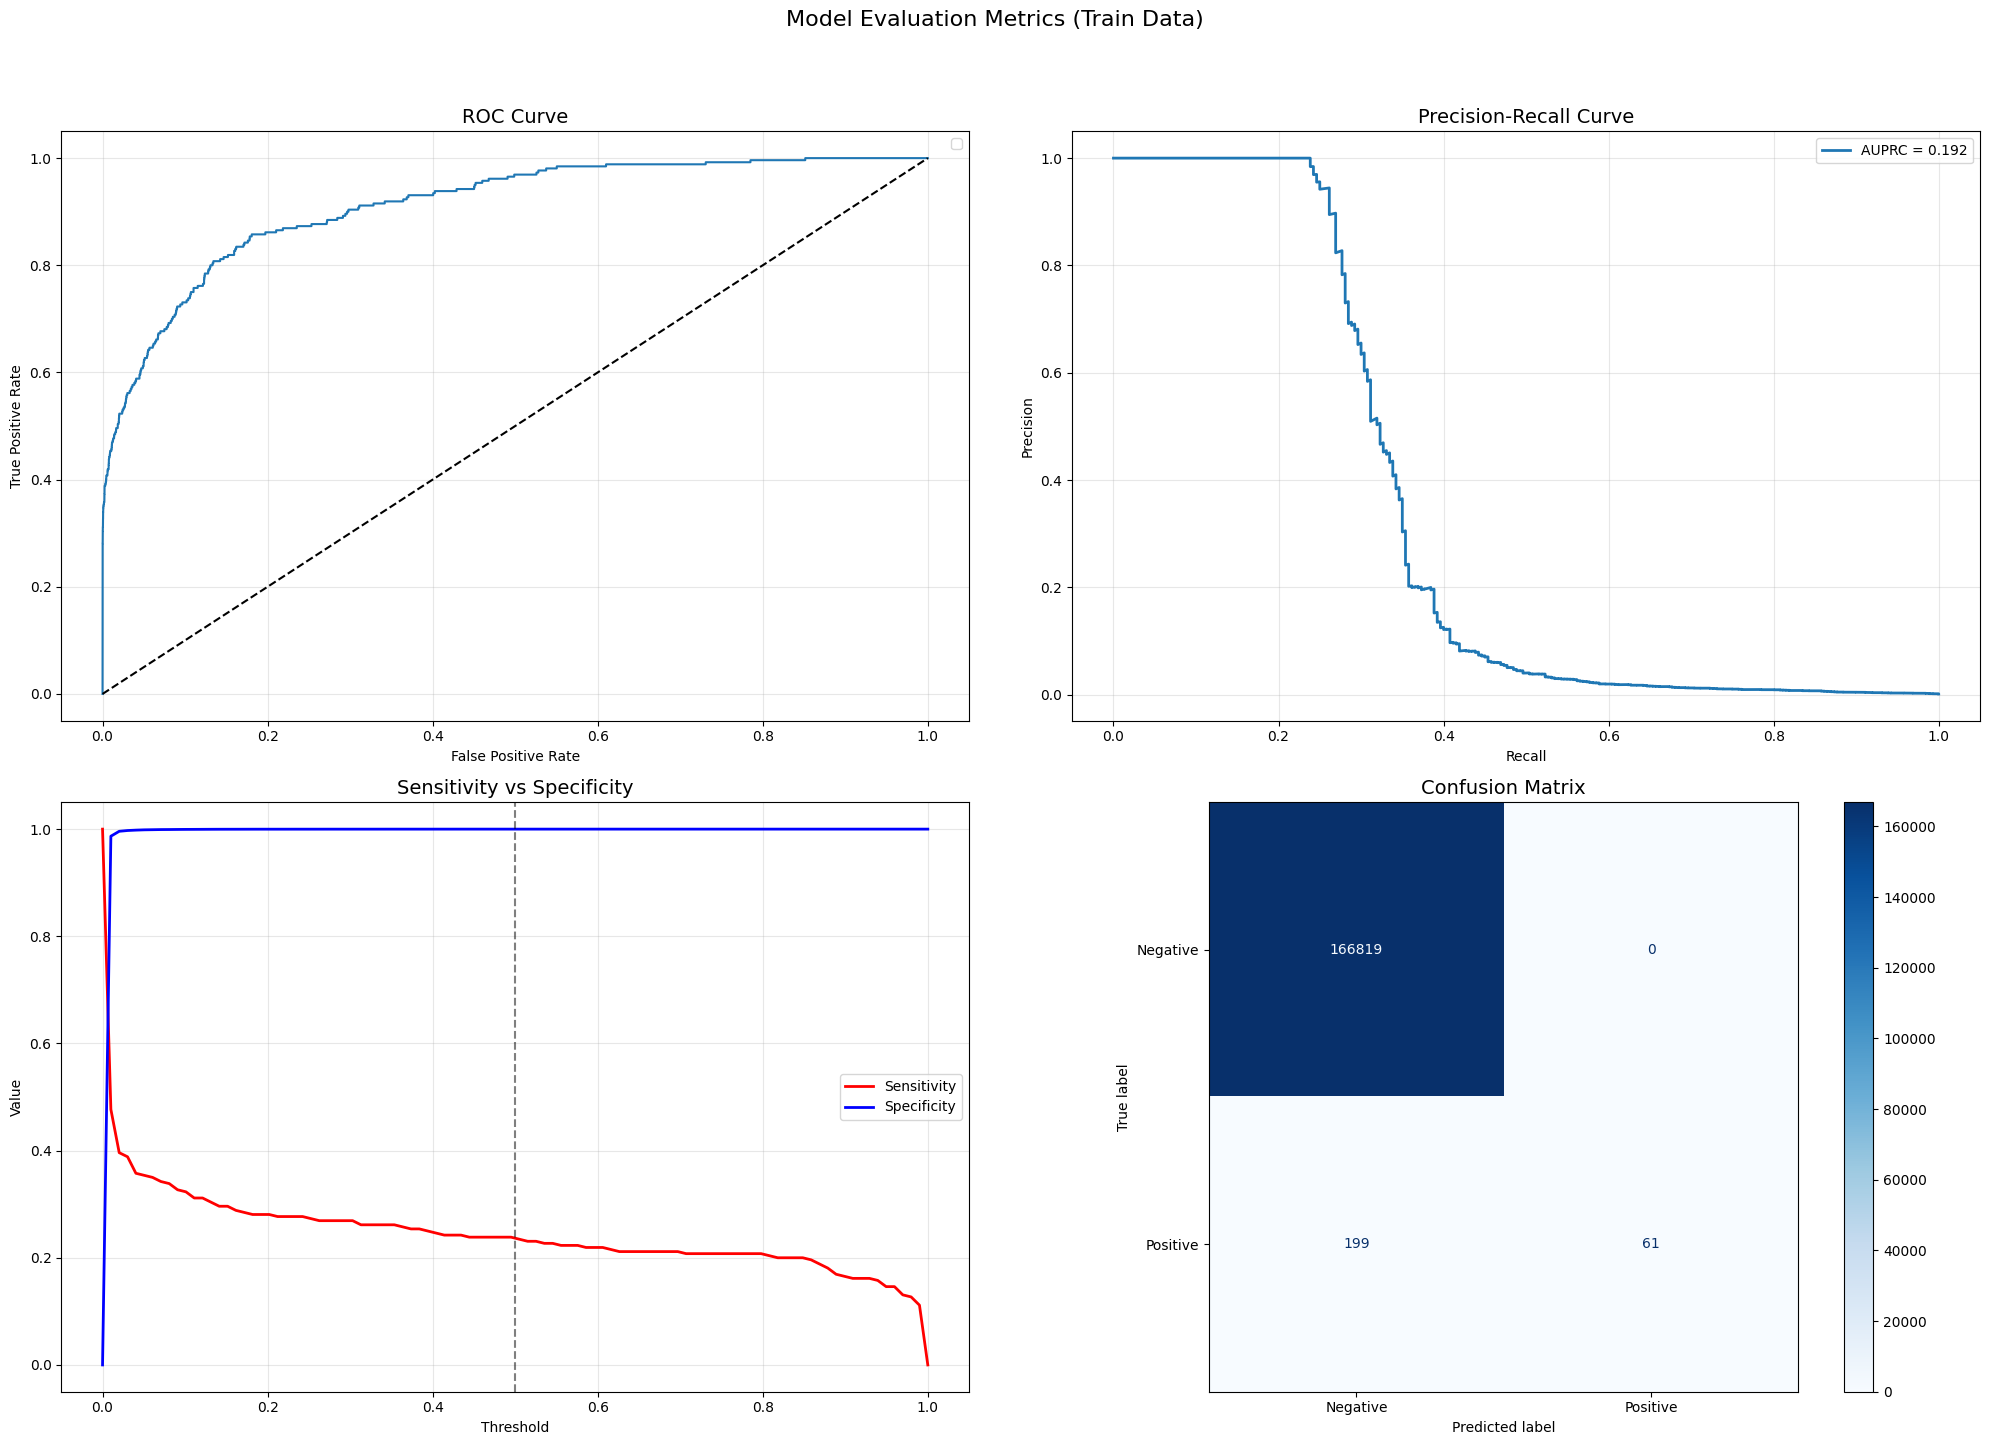

In [0]:
pandas_df = final_train_predictions.select("label", "prediction", "probability").toPandas()
pandas_df["probability_pos"] = pandas_df["probability"].apply(lambda x: x[1])

# Get data for calculations
y_true = pandas_df["label"]
y_pred = pandas_df["prediction"]
y_prob = pandas_df["probability_pos"]

threshold = 0.5 

# Multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

ax4 = plt.subplot(2, 2, 4)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)


plt.suptitle("Model Evaluation Metrics (Train Data)", fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])

In [0]:
# Make predictions on test data
final_test_predictions = final_model.transform(test_data)

# Evaluate the model
auroc = evaluator.evaluate(final_test_predictions)
print(f"Test AUROC: {auroc}")

Test AUROC: 0.5239031294873462


In [0]:
auprc = auprc_evaluator.evaluate(final_test_predictions)
recall = recall_evaluator.evaluate(final_test_predictions)
f1 = f1_evaluator.evaluate(final_test_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auroc}")
print(f"AUPRC: {auprc}")

Precision: 0.9988103657921114
Recall: 0.9974818316361468
F1 Score: 0.9963567028394589
AUC: 0.9097222830640519
AUPRC: 0.0024273312315221326


In [0]:
# Calculate metrics using PySpark DataFrame operations
from pyspark.sql.functions import sum, when, col

# Calculate TP, FP, TN, FN using DataFrame operations
metrics = final_test_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = final_test_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

In [0]:
print(f"TPR (True Positive Rate): {tpr:.4f}")
print(f"FPR (False Positive Rate): {fpr:.4f}")
print(f"PPV (Positive Predictive Value): {ppv:.4f}")

TPR (True Positive Rate): 0.0000
FPR (False Positive Rate): 0.0001
PPV (Positive Predictive Value): 0.0000


The model did not predict any accidents. This is likely because we did not use a weighted loss function or have any way to address the class imbalance. 

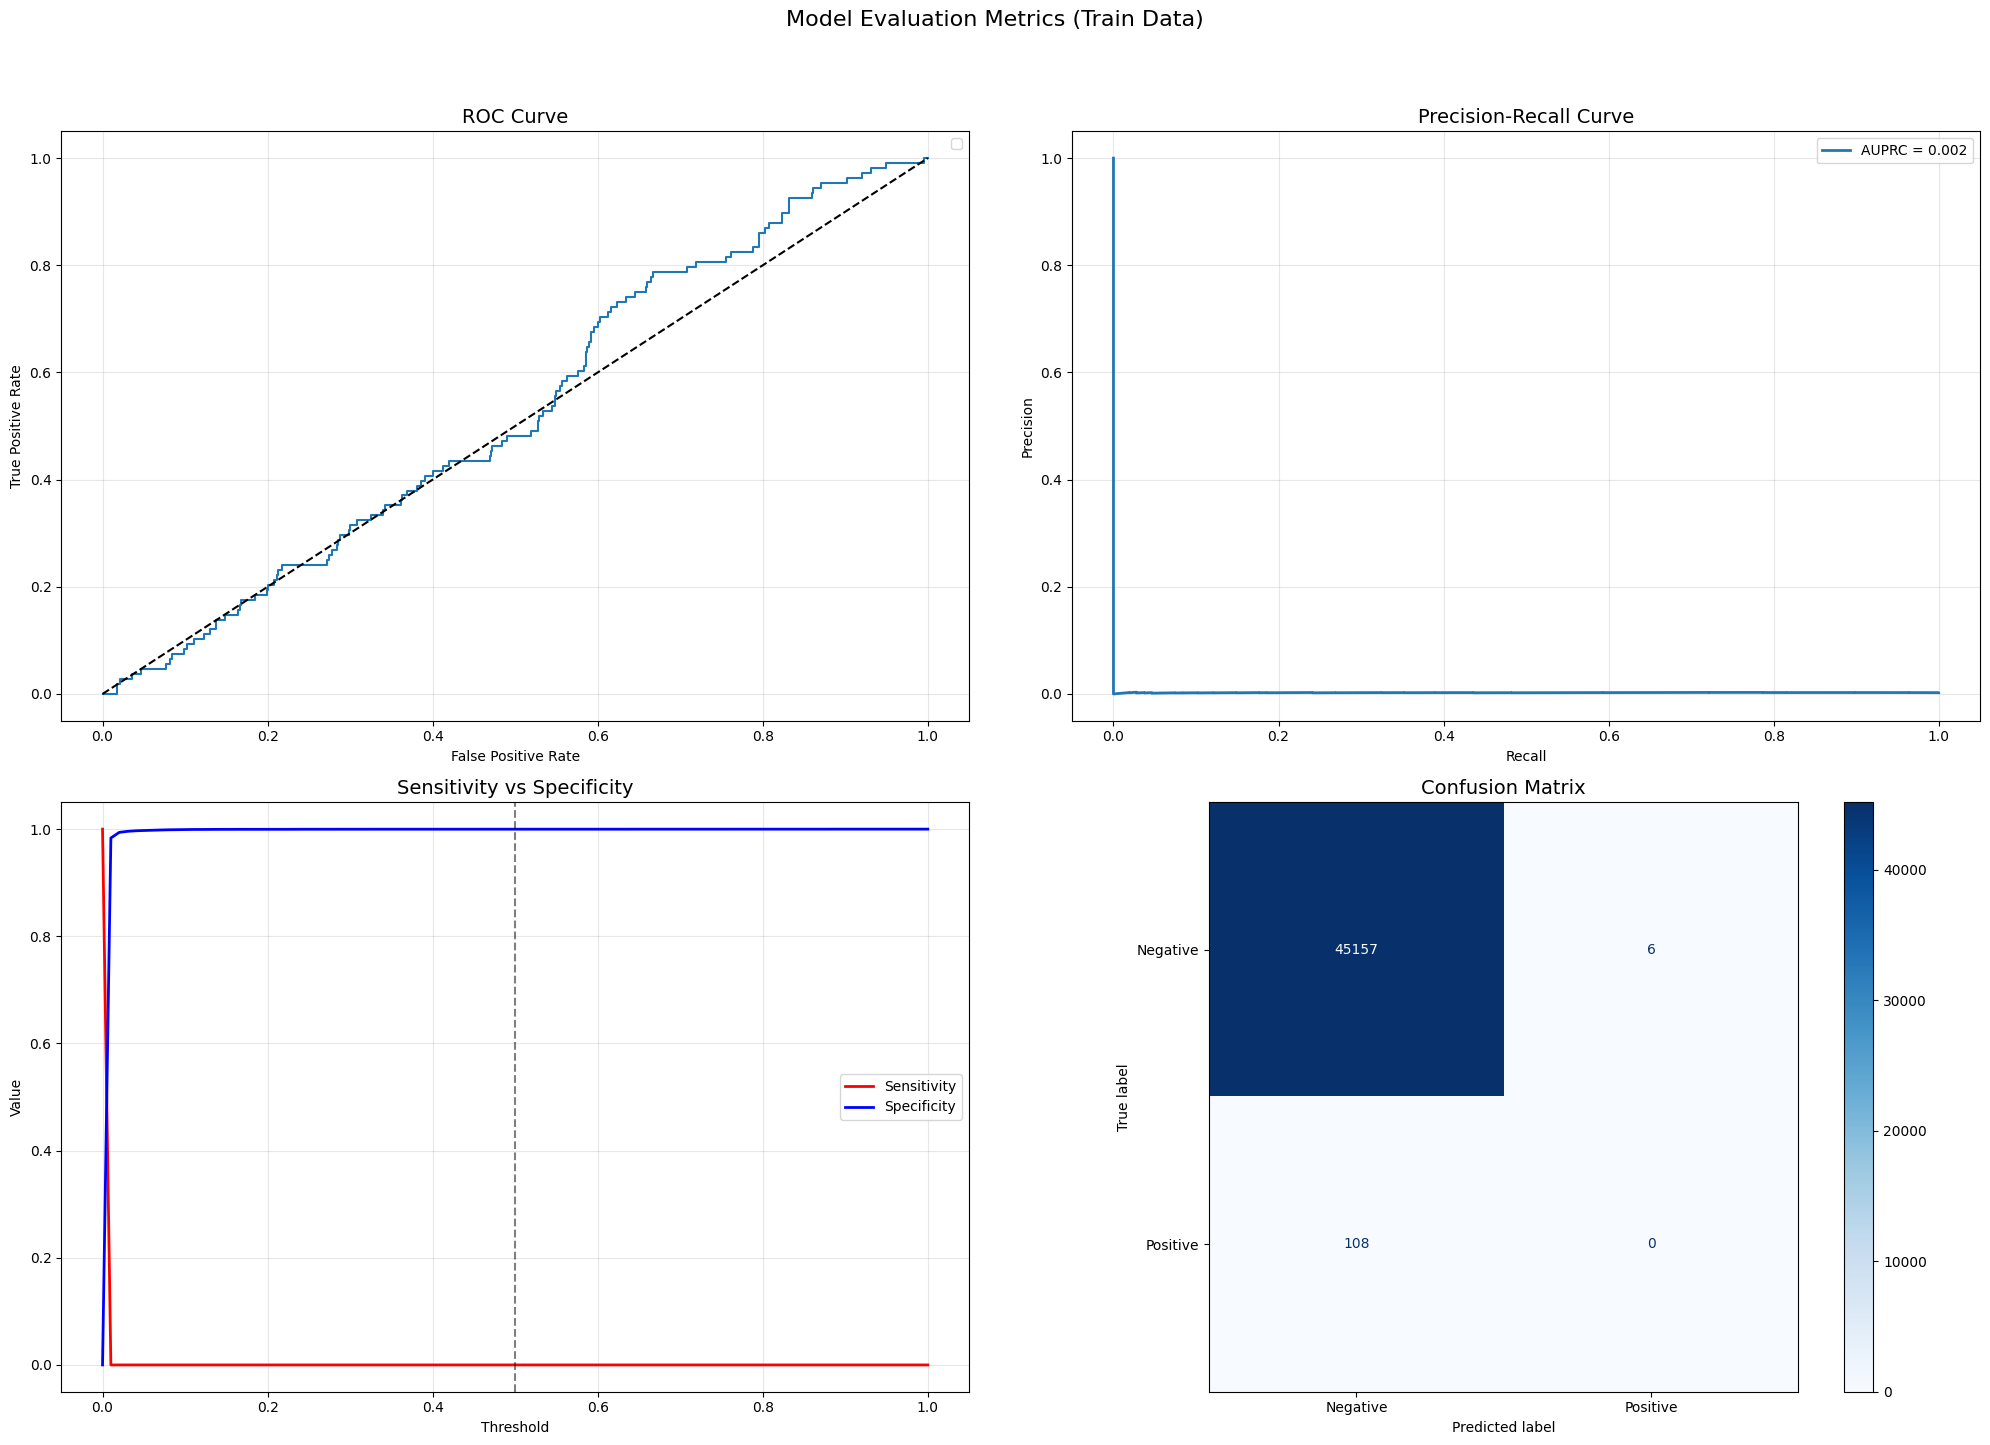

In [0]:
pandas_df = final_test_predictions.select("label", "prediction", "probability").toPandas()
pandas_df["probability_pos"] = pandas_df["probability"].apply(lambda x: x[1])

# Get data for calculations
y_true = pandas_df["label"]
y_pred = pandas_df["prediction"]
y_prob = pandas_df["probability_pos"]

threshold = 0.5 

# Multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)

ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

ax4 = plt.subplot(2, 2, 4)
ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"]).plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)


plt.suptitle("Model Evaluation Metrics (Train Data)", fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0.08, 1, 0.95])